# ITAEE

## Packages 

### Libraries

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta


# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

In [2]:
import geopandas as gpd

### Map polygons

In [3]:
# Read maps

# df_mun = gpd.read_file("../../../assets/maps/00mun.shp")
df_edo = gpd.read_file("../../../assets/maps/00ent.shp")

#INEGI - TUKAN geography mapping

inegi_tukan_map = pd.read_csv('../../../assets/maps/inegi_geography_map.csv', dtype={'CVEGEO':'str'})

# And we apply the mapping to the shapefile

df_edo = pd.merge(df_edo, inegi_tukan_map[['CVEGEO', 'CVEGEO_tukan']], how = 'left', on = 'CVEGEO')
# df_edo = pd.merge(df_edo, inegi_tukan_map[['CVEGEO', 'CVEGEO_tukan']], how = 'left', on = 'CVEGEO')

#Rename columns
df_edo.rename(columns = {'CVEGEO_tukan':'geography__ref'}, inplace = True)
# df_edo.rename(columns = {'CVEGEO_tukan':'geography__ref'}, inplace = True)

## (A) Quarterly change plots

###  1 . All economic activities, seasonal adjustment

#### Payload

In [400]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": [
            "61060325ab095ed"
        ],
        "economic_activity": "all",
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ],
    "from": "2020-01-27"
}

response = get_tukan_api_request(payload)
data = response["data"]
data['date'].unique()

Success getting the data


array(['2020-01-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2020-07-01T00:00:00.000000000', '2020-10-01T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2021-04-01T00:00:00.000000000',
       '2021-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Filtering data

In [401]:
data = data[(data["date"] == "2021-04-01") | (data["date"] == "2021-07-01")].reset_index(drop = True)# change dates
data['prev_qtr'] = data.groupby(['geography__ref'])['92748be9624675d'].shift()
data = data[data['date']== "2021-07-01"].reset_index(drop = True)
data['qtrly_var'] = (data['92748be9624675d']/data['prev_qtr'])-1
# data

#### Merging data and polygons

In [402]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="qtrly_var", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,adjustment_type__ref,adjustment_type,economic_activity__ref,economic_activity,geography,92748be9624675d,prev_qtr,qtrly_var
28,29,29,Tlaxcala,"POLYGON ((2912153.554 863641.586, 2912195.798 ...",5ec6f2e8362d8b2,2021-07-01,61060325ab095ed,Ajuste estacional,dfeefc621d16d0c,Actividad económica,Tlaxcala,111.954869,107.736171,0.039158
26,27,27,Tabasco,"POLYGON ((3505265.800 767356.609, 3505486.100 ...",66fc4903e4ffb94,2021-07-01,61060325ab095ed,Ajuste estacional,dfeefc621d16d0c,Actividad económica,Tabasco,94.685907,90.668221,0.044312
22,23,23,Quintana Roo,"MULTIPOLYGON (((4039086.131 787620.709, 403895...",ff9e50f58bb1ce3,2021-07-01,61060325ab095ed,Ajuste estacional,dfeefc621d16d0c,Actividad económica,Quintana Roo,113.827304,105.931489,0.074537


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


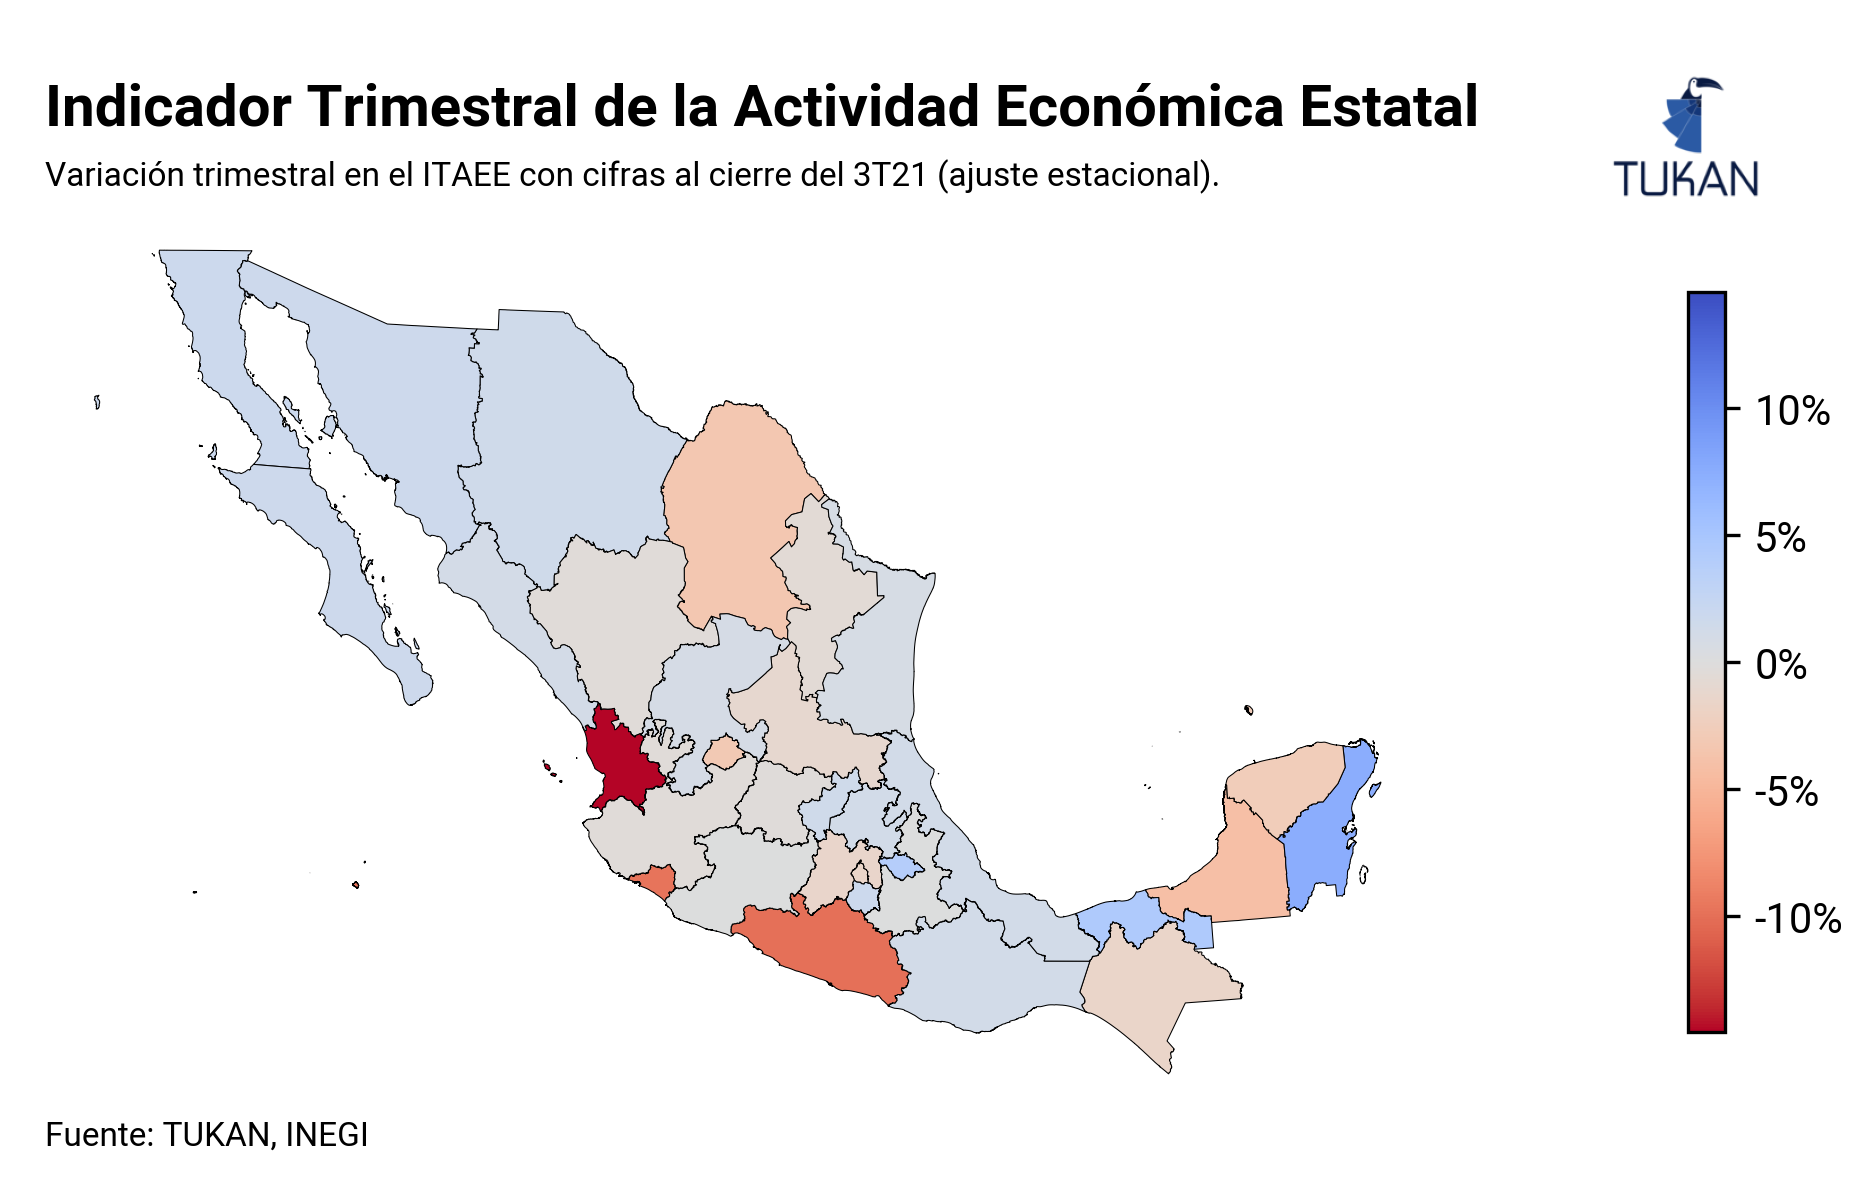

In [403]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()
y_limit = max(abs(data['qtrly_var'].min()),abs(data['qtrly_var'].max()))

data.plot("qtrly_var", ax = ax1, cmap = "coolwarm_r", linewidths = 0.25, edgecolor = "black", norm=mpl.colors.TwoSlopeNorm(vmin=-y_limit, vcenter=0, vmax=y_limit))

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['qtrly_var'], axis=0)
heatmap=ax2.imshow(a, cmap = "coolwarm_r", norm=mpl.colors.TwoSlopeNorm(vmin=-y_limit, vcenter=0, vmax=y_limit))
heatmap.set_visible(False) #coolwarm seismic_r

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Indicador Trimestral de la Actividad Económica Estatal",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación trimestral en el ITAEE con cifras al cierre del 3T21 (ajuste estacional).", #change dates
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/quarterly_growth_all_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  2 . Commerce

#### Payload

In [404]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "1d0185629b65ee3"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ],
    "from": "2020-01-27"
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [405]:
data = data[(data["date"] == "2021-04-01") | (data["date"] == "2021-07-01")].reset_index(drop = True) # change dates
data['prev_qtr'] = data.groupby(['geography__ref'])['92748be9624675d'].shift()
data = data[data['date']== "2021-07-01"].reset_index(drop = True)
data['qtrly_var'] = (data['92748be9624675d']/data['prev_qtr'])-1
# data

#### Merging data and polygons

In [406]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="qtrly_var", ascending = True).tail(5)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d,prev_qtr,qtrly_var
29,30,30,Veracruz de Ignacio de la Llave,"MULTIPOLYGON (((3119599.686 810246.093, 311958...",f22e4d8e77ae9bf,2021-07-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Veracruz de Ignacio de la Llave,121.049957,112.725556,0.073847
12,13,13,Hidalgo,"POLYGON ((2862894.736 1047165.224, 2862941.878...",361653ebbec7c01,2021-07-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Hidalgo,118.681419,108.270820,0.096153
28,29,29,Tlaxcala,"POLYGON ((2912153.554 863641.586, 2912195.798 ...",5ec6f2e8362d8b2,2021-07-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Tlaxcala,144.196855,131.390984,0.097464
2,03,03,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",360a302c378e710,2021-07-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Baja California Sur,139.907212,127.043279,0.101256
5,06,06,Colima,"MULTIPOLYGON (((1157633.318 768573.525, 115772...",1066aeadf0e6b1d,2021-07-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Colima,136.794586,121.408794,0.126727


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


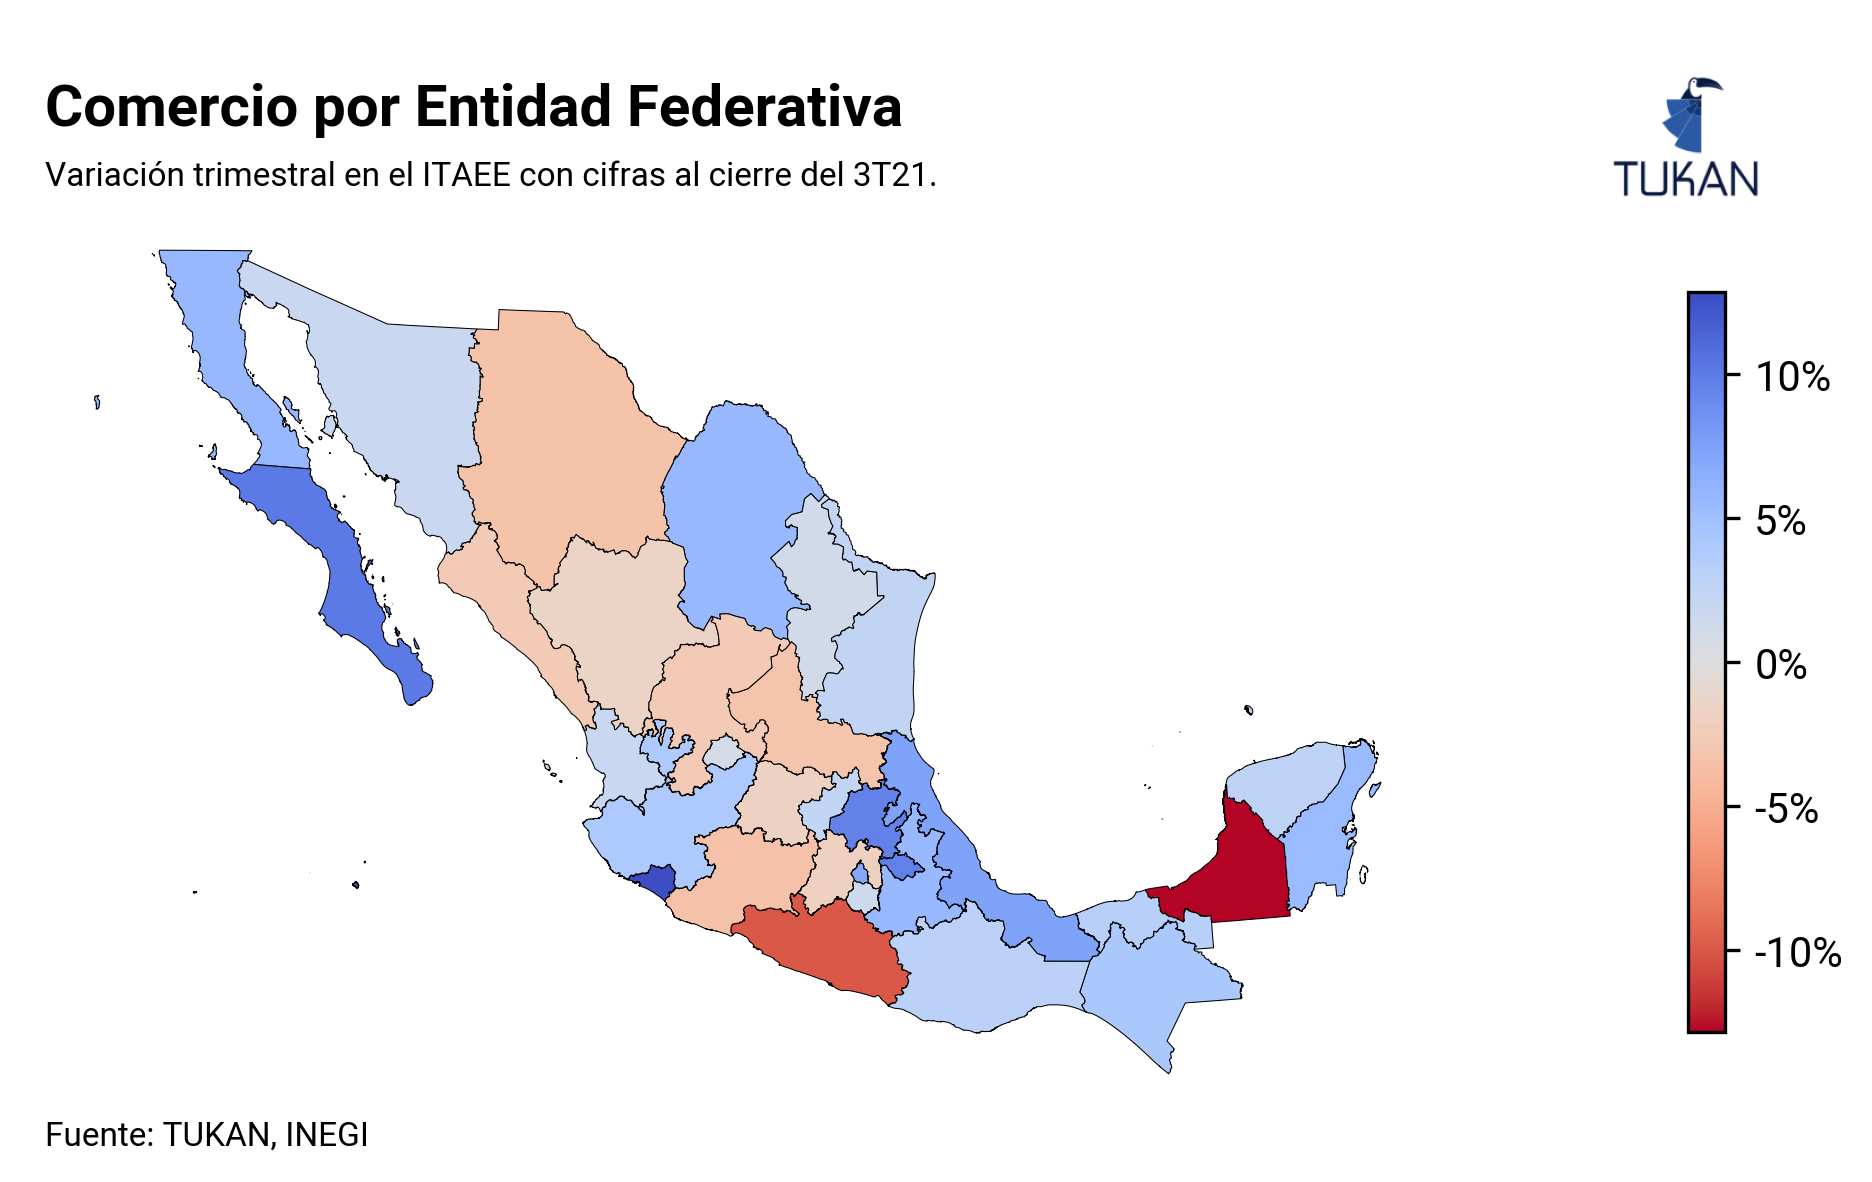

In [407]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()
y_limit = max(abs(data['qtrly_var'].min()),abs(data['qtrly_var'].max()))


data.plot("qtrly_var", ax = ax1, cmap = "coolwarm_r", linewidths = 0.25, edgecolor = "black", norm=mpl.colors.TwoSlopeNorm(vmin=-y_limit, vcenter=0, vmax=y_limit))

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['qtrly_var'], axis=0)
heatmap=ax2.imshow(a, cmap = "coolwarm_r", norm=mpl.colors.TwoSlopeNorm(vmin=-y_limit, vcenter=0, vmax=y_limit))
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Comercio por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación trimestral en el ITAEE con cifras al cierre del 3T21.", #change dates
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/quarterly_growth_commerce_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  3 . Manufacture

#### Payload

In [408]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "faa2a8d0af8a72c"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ],
    "from": "2020-01-27"
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [409]:
data = data[(data["date"] == "2021-04-01") | (data["date"] == "2021-07-01")].reset_index(drop = True) # change dates
data['prev_qtr'] = data.groupby(['geography__ref'])['92748be9624675d'].shift()
data = data[data['date']== "2021-07-01"].reset_index(drop = True)
data['qtrly_var'] = (data['92748be9624675d']/data['prev_qtr'])-1
# data

#### Merging data and polygons

In [410]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="qtrly_var", ascending = True).tail(5)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d,prev_qtr,qtrly_var
12,13,13,Hidalgo,"POLYGON ((2862894.736 1047165.224, 2862941.878...",361653ebbec7c01,2021-07-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Hidalgo,108.503758,103.421265,0.049144
26,27,27,Tabasco,"POLYGON ((3505265.800 767356.609, 3505486.100 ...",66fc4903e4ffb94,2021-07-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Tabasco,75.249403,71.492243,0.052553
28,29,29,Tlaxcala,"POLYGON ((2912153.554 863641.586, 2912195.798 ...",5ec6f2e8362d8b2,2021-07-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Tlaxcala,115.208873,108.908533,0.057850
8,09,09,Ciudad de México,"POLYGON ((2802175.660 843326.718, 2801806.564 ...",a3610ba4cc376e9,2021-07-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Ciudad de México,98.219560,92.719486,0.059320
21,22,22,Querétaro,"POLYGON ((2789578.589 1075590.981, 2790053.712...",c8632592a7df381,2021-07-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Querétaro,143.232203,135.106956,0.060139


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


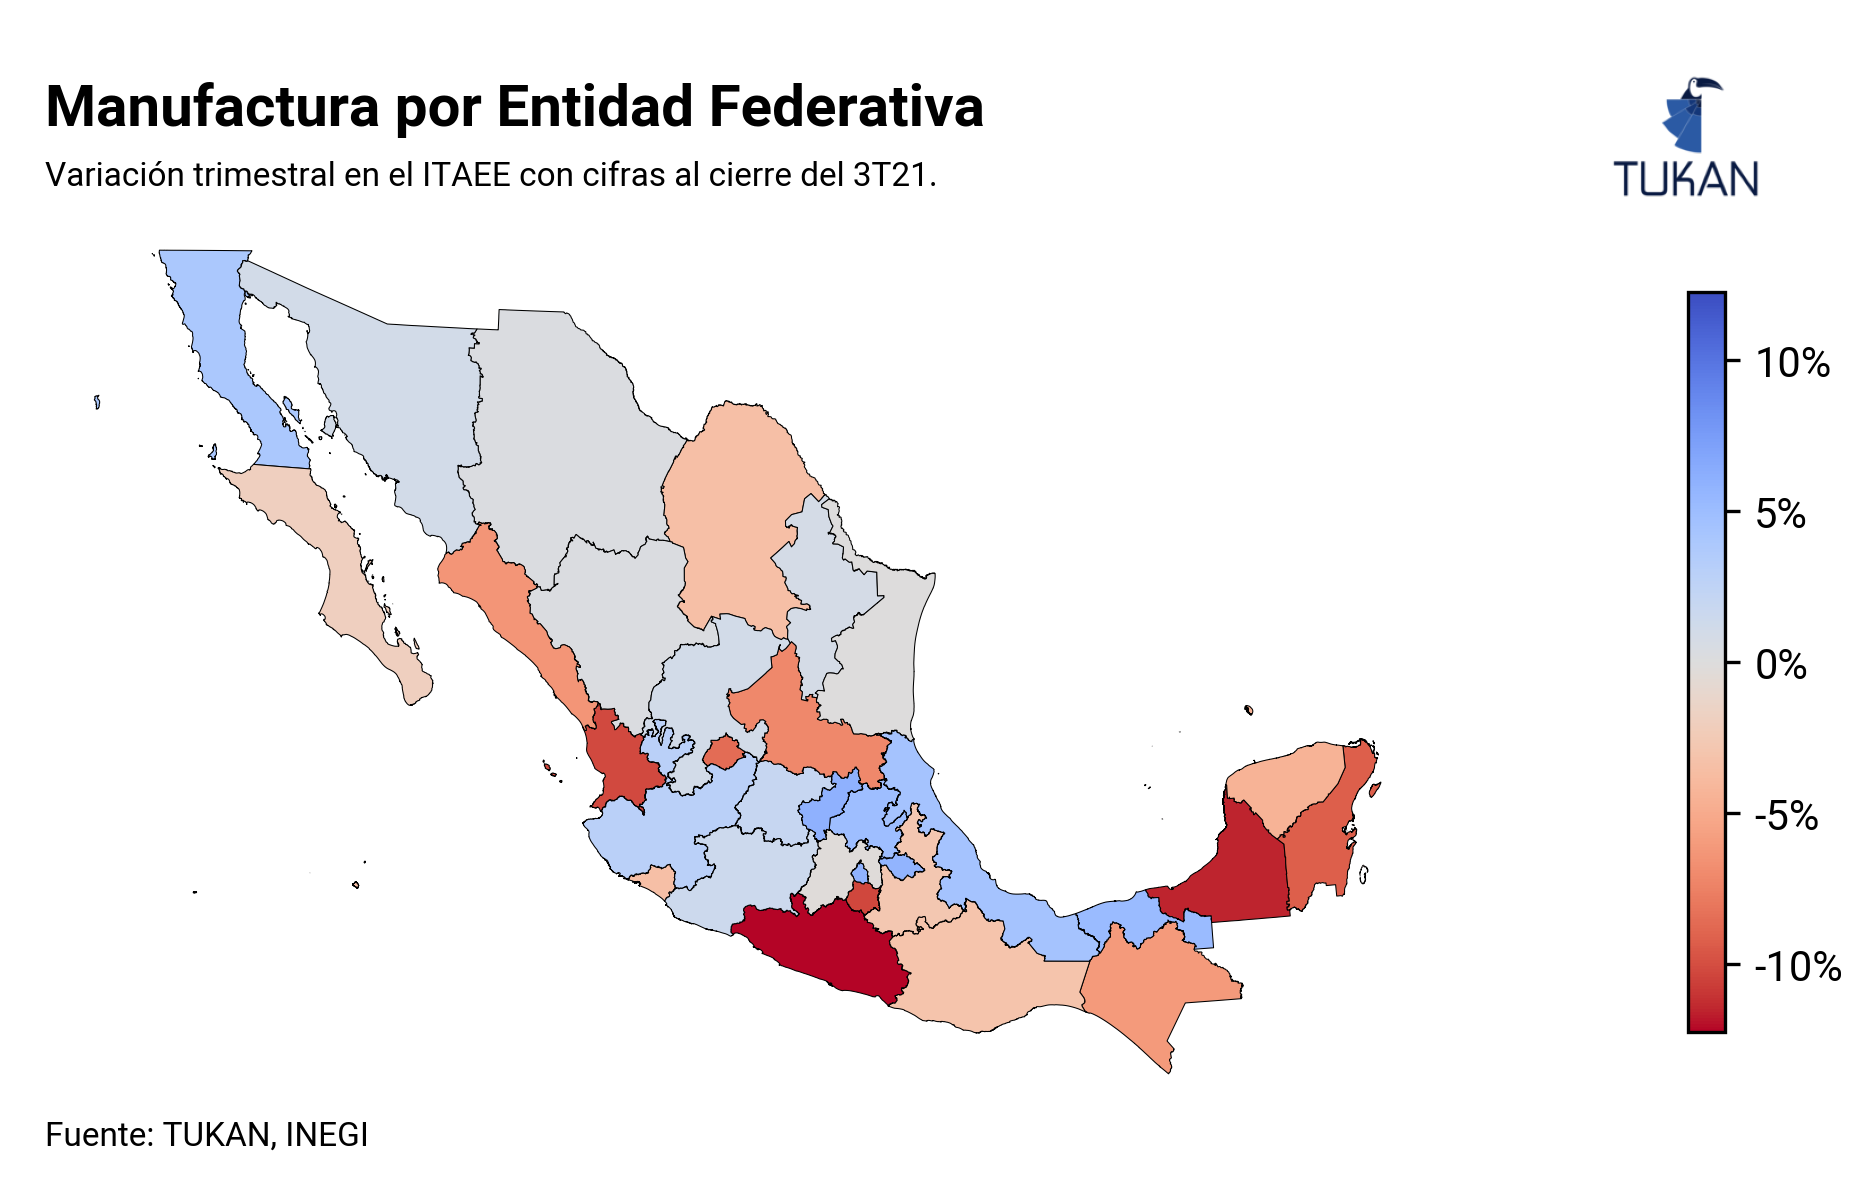

In [411]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])
y_limit = max(abs(data['qtrly_var'].min()),abs(data['qtrly_var'].max()))


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("qtrly_var", ax = ax1, cmap = "coolwarm_r", linewidths = 0.25, edgecolor = "black", norm=mpl.colors.TwoSlopeNorm(vmin=-y_limit, vcenter=0, vmax=y_limit))

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['qtrly_var'], axis=0)
heatmap=ax2.imshow(a, cmap = "coolwarm_r", norm=mpl.colors.TwoSlopeNorm(vmin=-y_limit, vcenter=0, vmax=y_limit))
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Manufactura por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación trimestral en el ITAEE con cifras al cierre del 3T21.", #change dates
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/quarterly_growth_manufacturing_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

## (B) Yearly change plots (WIP)

###  1 . Commerce

#### Payload

In [412]:
payload = {
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "1d0185629b65ee3"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ]
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [413]:
# data is ready to go
data['date'].unique()

array(['2021-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Merging data and polygons

In [414]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="92748be9624675d", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d
30,31,31,Yucatán,"MULTIPOLYGON (((3511760.832 1023282.324, 35117...",4beb98148056b4e,2021-07-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Yucatán,0.183781
2,03,03,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",360a302c378e710,2021-07-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Baja California Sur,0.240122
22,23,23,Quintana Roo,"MULTIPOLYGON (((4039086.131 787620.709, 403895...",ff9e50f58bb1ce3,2021-07-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Quintana Roo,0.294057


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


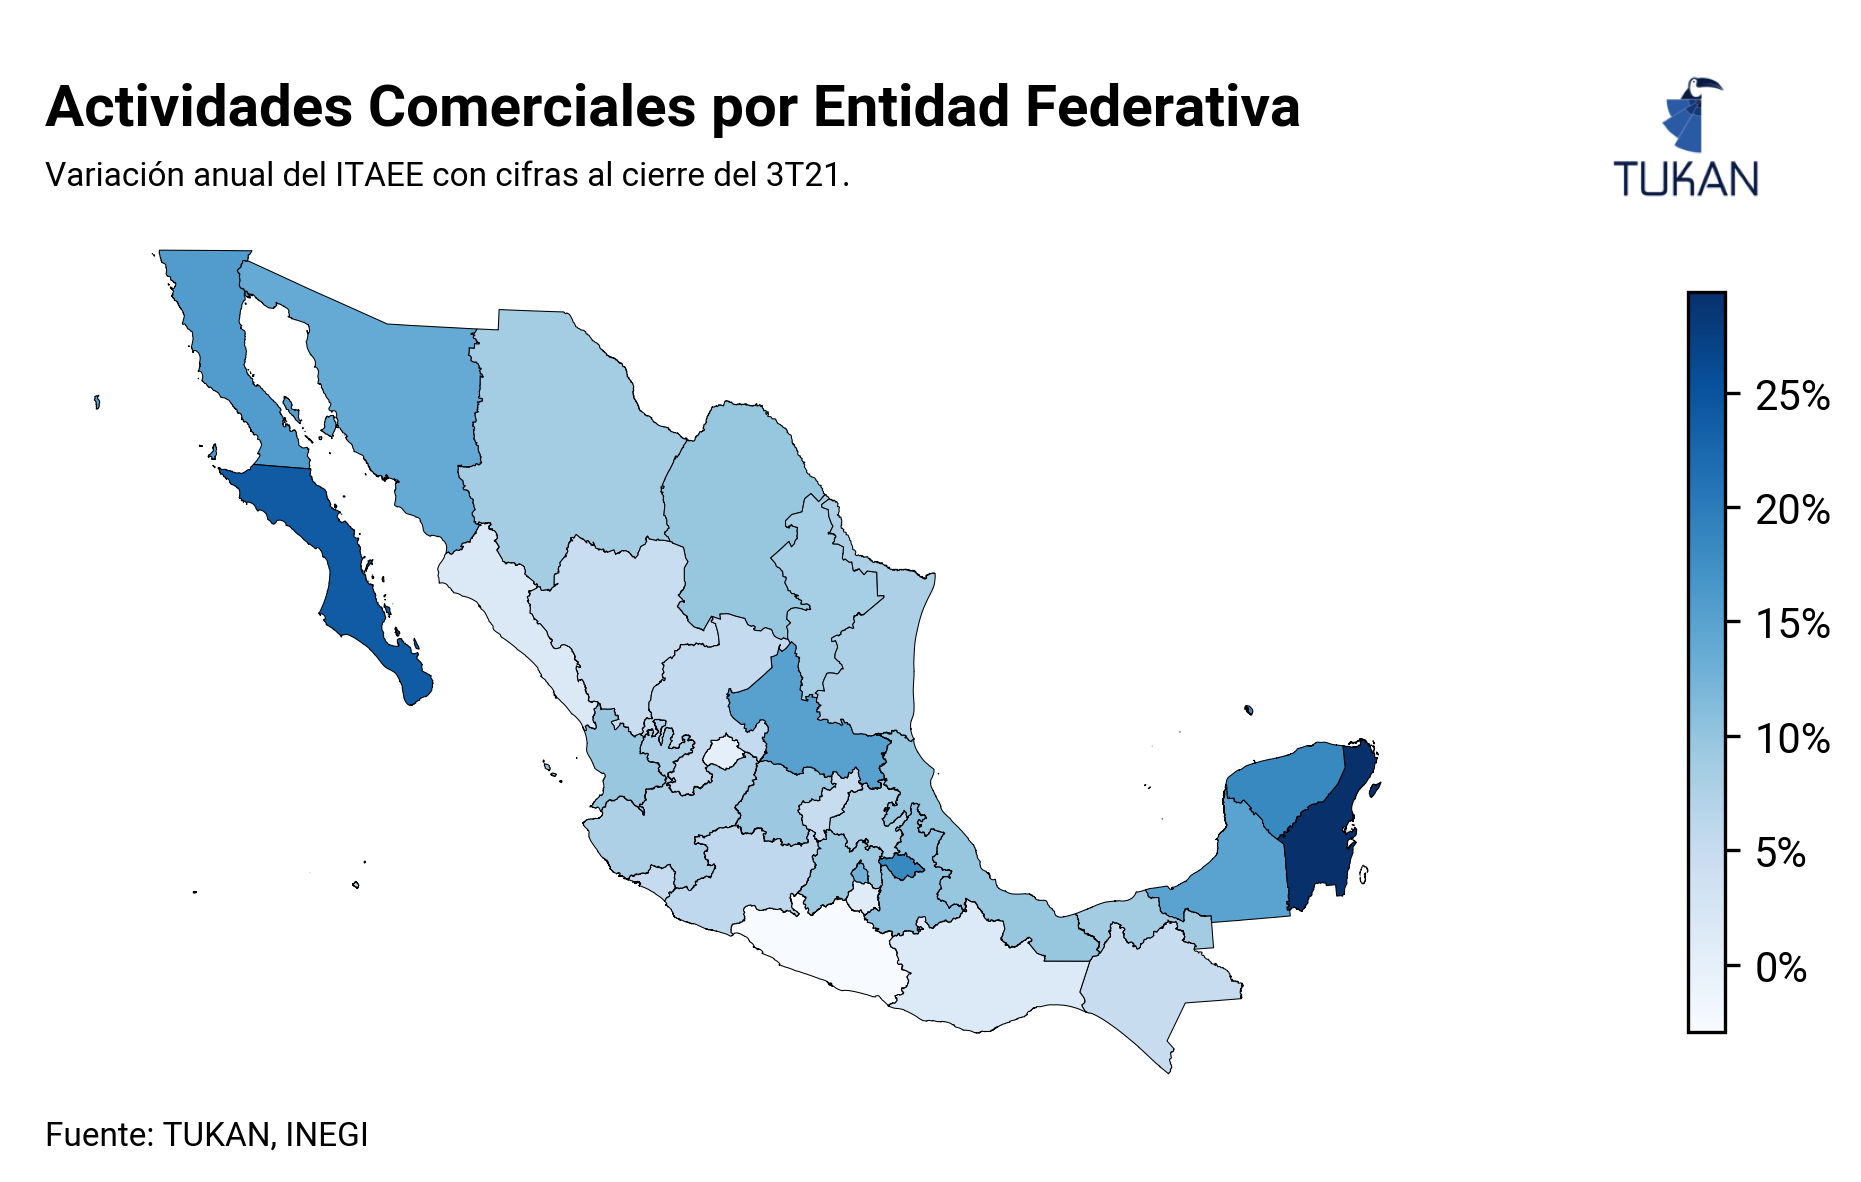

In [415]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("92748be9624675d", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['92748be9624675d'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividades Comerciales por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación anual del ITAEE con cifras al cierre del 3T21.", #change dates
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/yearly_growth_commerce_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  2 . Manufacture

#### Payload

In [416]:
payload = {
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "faa2a8d0af8a72c"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ]
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [417]:
# data is ready to go
data['date'].unique()

array(['2021-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Merging data and polygons

In [418]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="92748be9624675d", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d
29,30,30,Veracruz de Ignacio de la Llave,"MULTIPOLYGON (((3119599.686 810246.093, 311958...",f22e4d8e77ae9bf,2021-07-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Veracruz de Ignacio de la Llave,0.165704
12,13,13,Hidalgo,"POLYGON ((2862894.736 1047165.224, 2862941.878...",361653ebbec7c01,2021-07-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Hidalgo,0.171744
22,23,23,Quintana Roo,"MULTIPOLYGON (((4039086.131 787620.709, 403895...",ff9e50f58bb1ce3,2021-07-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Quintana Roo,0.188103


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


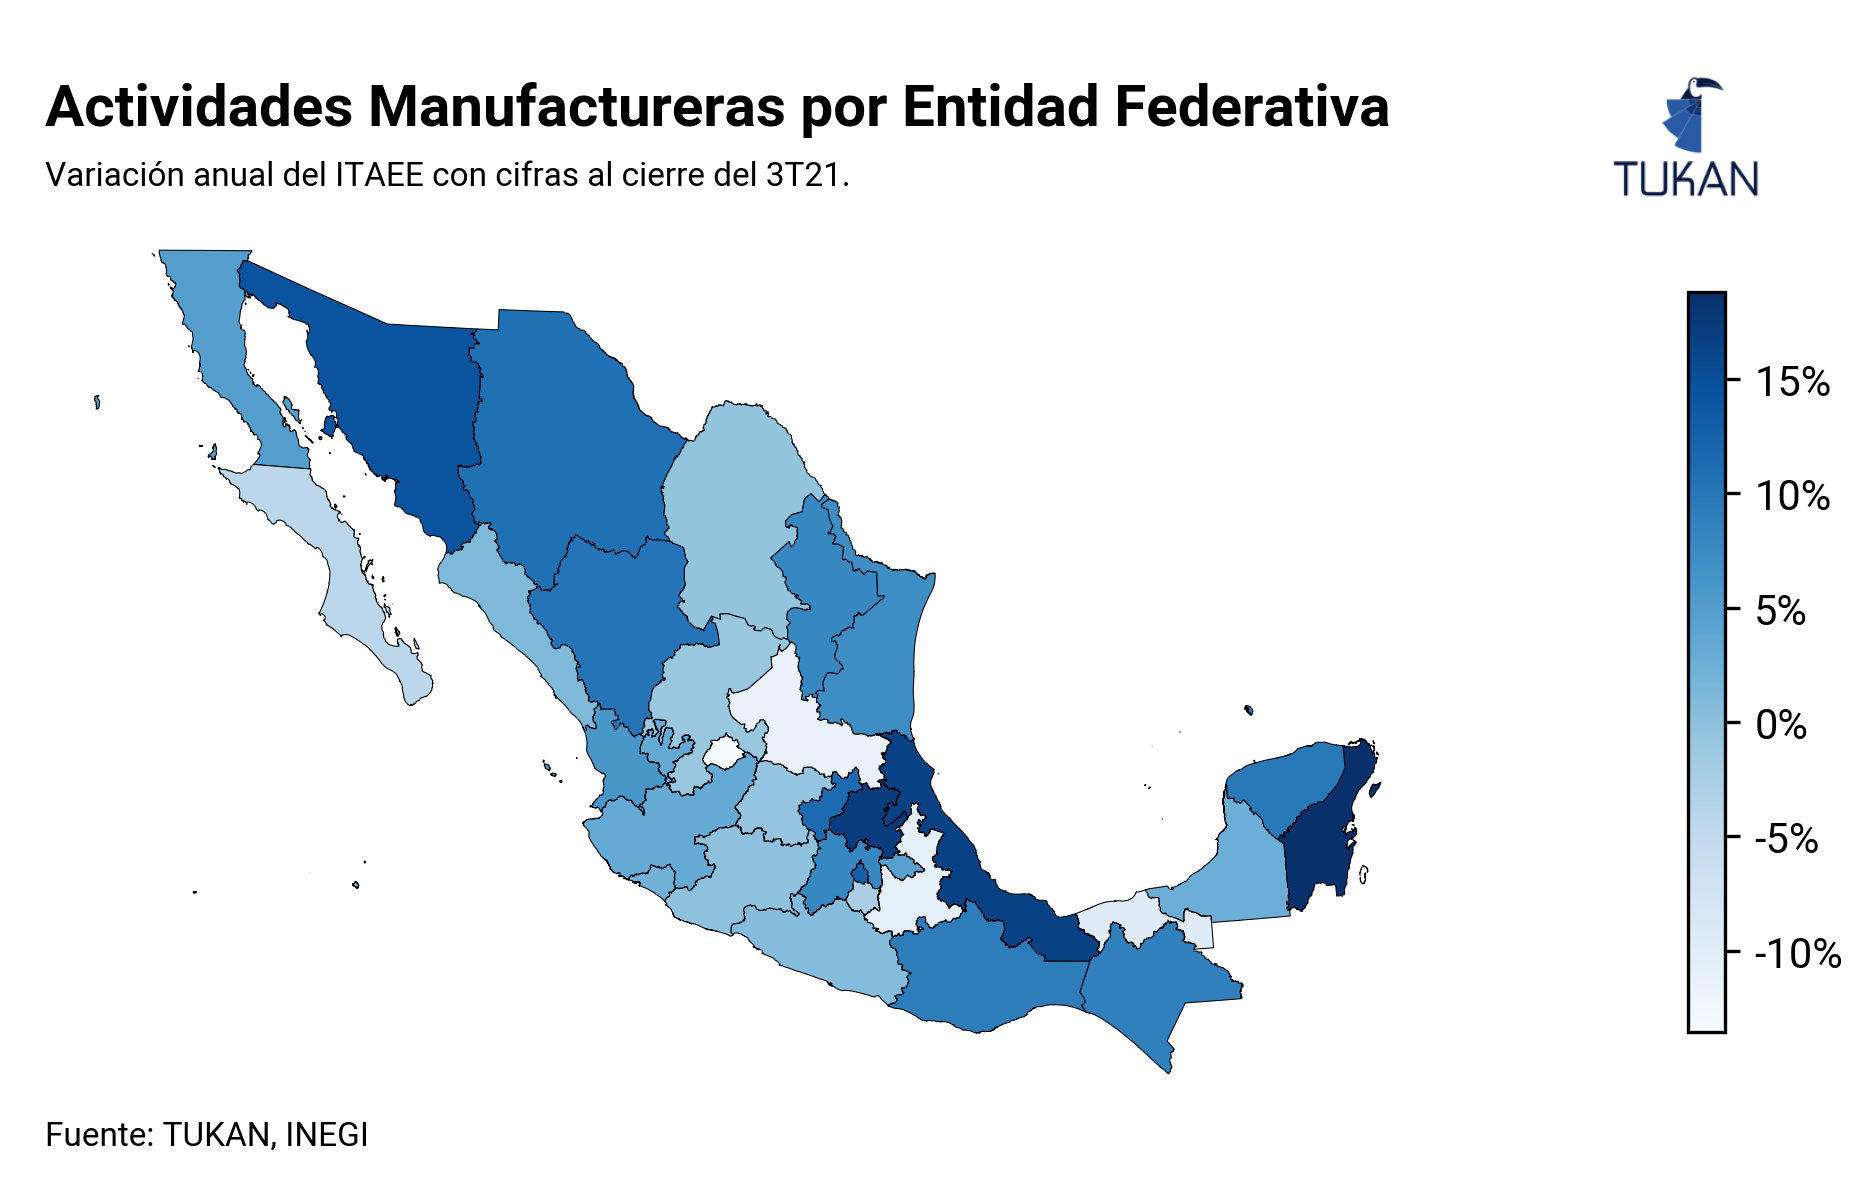

In [419]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("92748be9624675d", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['92748be9624675d'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividades Manufactureras por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación anual del ITAEE con cifras al cierre del 3T21.", #change dates
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/yearly_growth_manufacturing_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  3 . Primary activities

#### Payload

In [420]:
payload = {
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "7460634ca523beb"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ]
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [421]:
# data is ready to go
data['date'].unique()

array(['2021-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Merging data and polygons

In [422]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="92748be9624675d", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d
22,23,23,Quintana Roo,"MULTIPOLYGON (((4039086.131 787620.709, 403895...",ff9e50f58bb1ce3,2021-07-01,7460634ca523beb,Actividades primarias,a7e5d5a7d084363,Original,Quintana Roo,0.334767
2,03,03,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",360a302c378e710,2021-07-01,7460634ca523beb,Actividades primarias,a7e5d5a7d084363,Original,Baja California Sur,0.339060
27,28,28,Tamaulipas,"POLYGON ((2724530.125 1735179.945, 2724595.848...",4f875e6e2443514,2021-07-01,7460634ca523beb,Actividades primarias,a7e5d5a7d084363,Original,Tamaulipas,0.643827


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


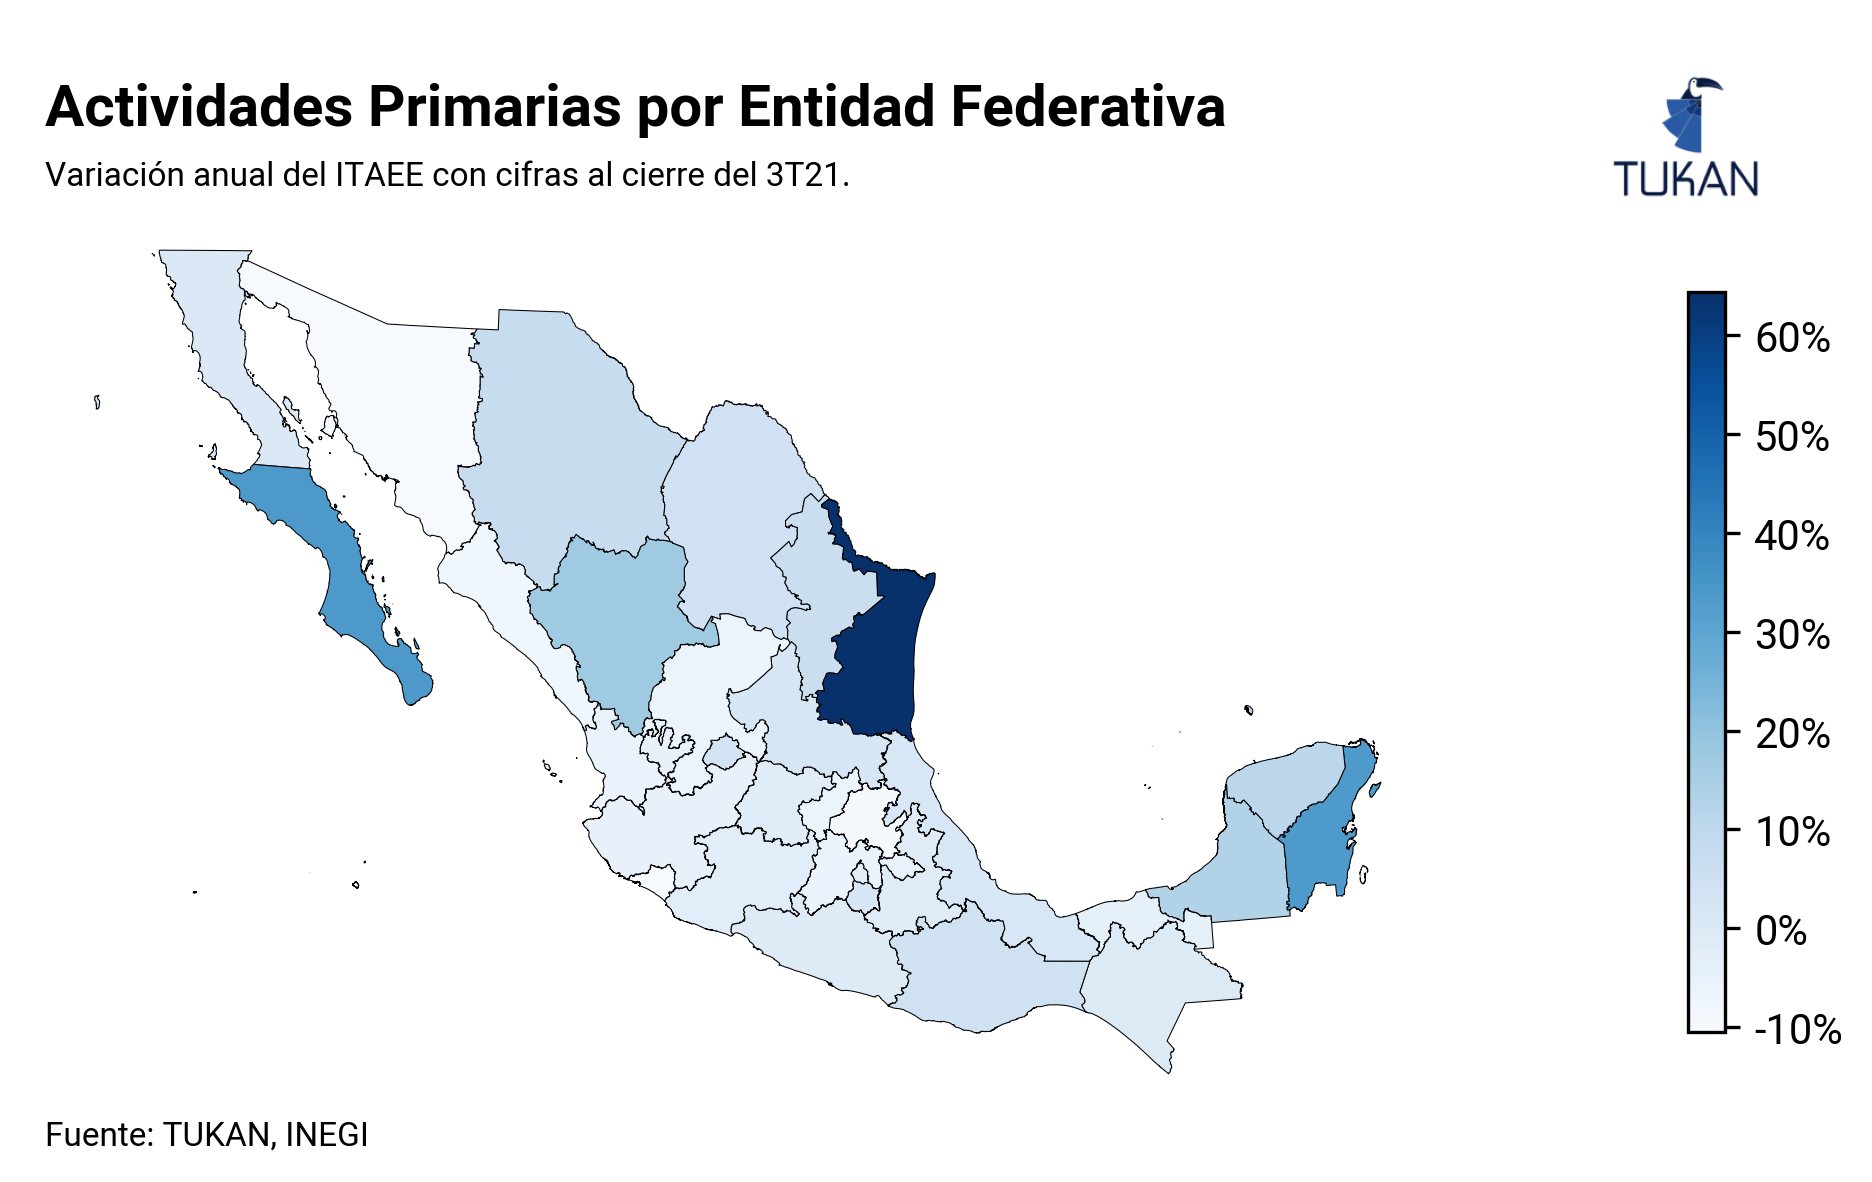

In [423]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("92748be9624675d", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['92748be9624675d'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividades Primarias por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación anual del ITAEE con cifras al cierre del 3T21.", #change dates
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/yearly_growth_primary_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  4 . Secondary activities

#### Payload

In [424]:
payload = {
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "761bc00426e1c48"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ]
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [425]:
# data is ready to go
data['date'].unique()

array(['2021-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Merging data and polygons

In [426]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="92748be9624675d", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d
19,20,20,Oaxaca,"MULTIPOLYGON (((3120848.310 424036.022, 312086...",16600f577a6aa5d,2021-07-01,761bc00426e1c48,Actividades secundarias,a7e5d5a7d084363,Original,Oaxaca,0.155504
26,27,27,Tabasco,"POLYGON ((3505265.800 767356.609, 3505486.100 ...",66fc4903e4ffb94,2021-07-01,761bc00426e1c48,Actividades secundarias,a7e5d5a7d084363,Original,Tabasco,0.183855
17,18,18,Nayarit,"MULTIPOLYGON (((2161261.691 1008297.886, 21612...",d3d2e9958774cf3,2021-07-01,761bc00426e1c48,Actividades secundarias,a7e5d5a7d084363,Original,Nayarit,0.260822


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


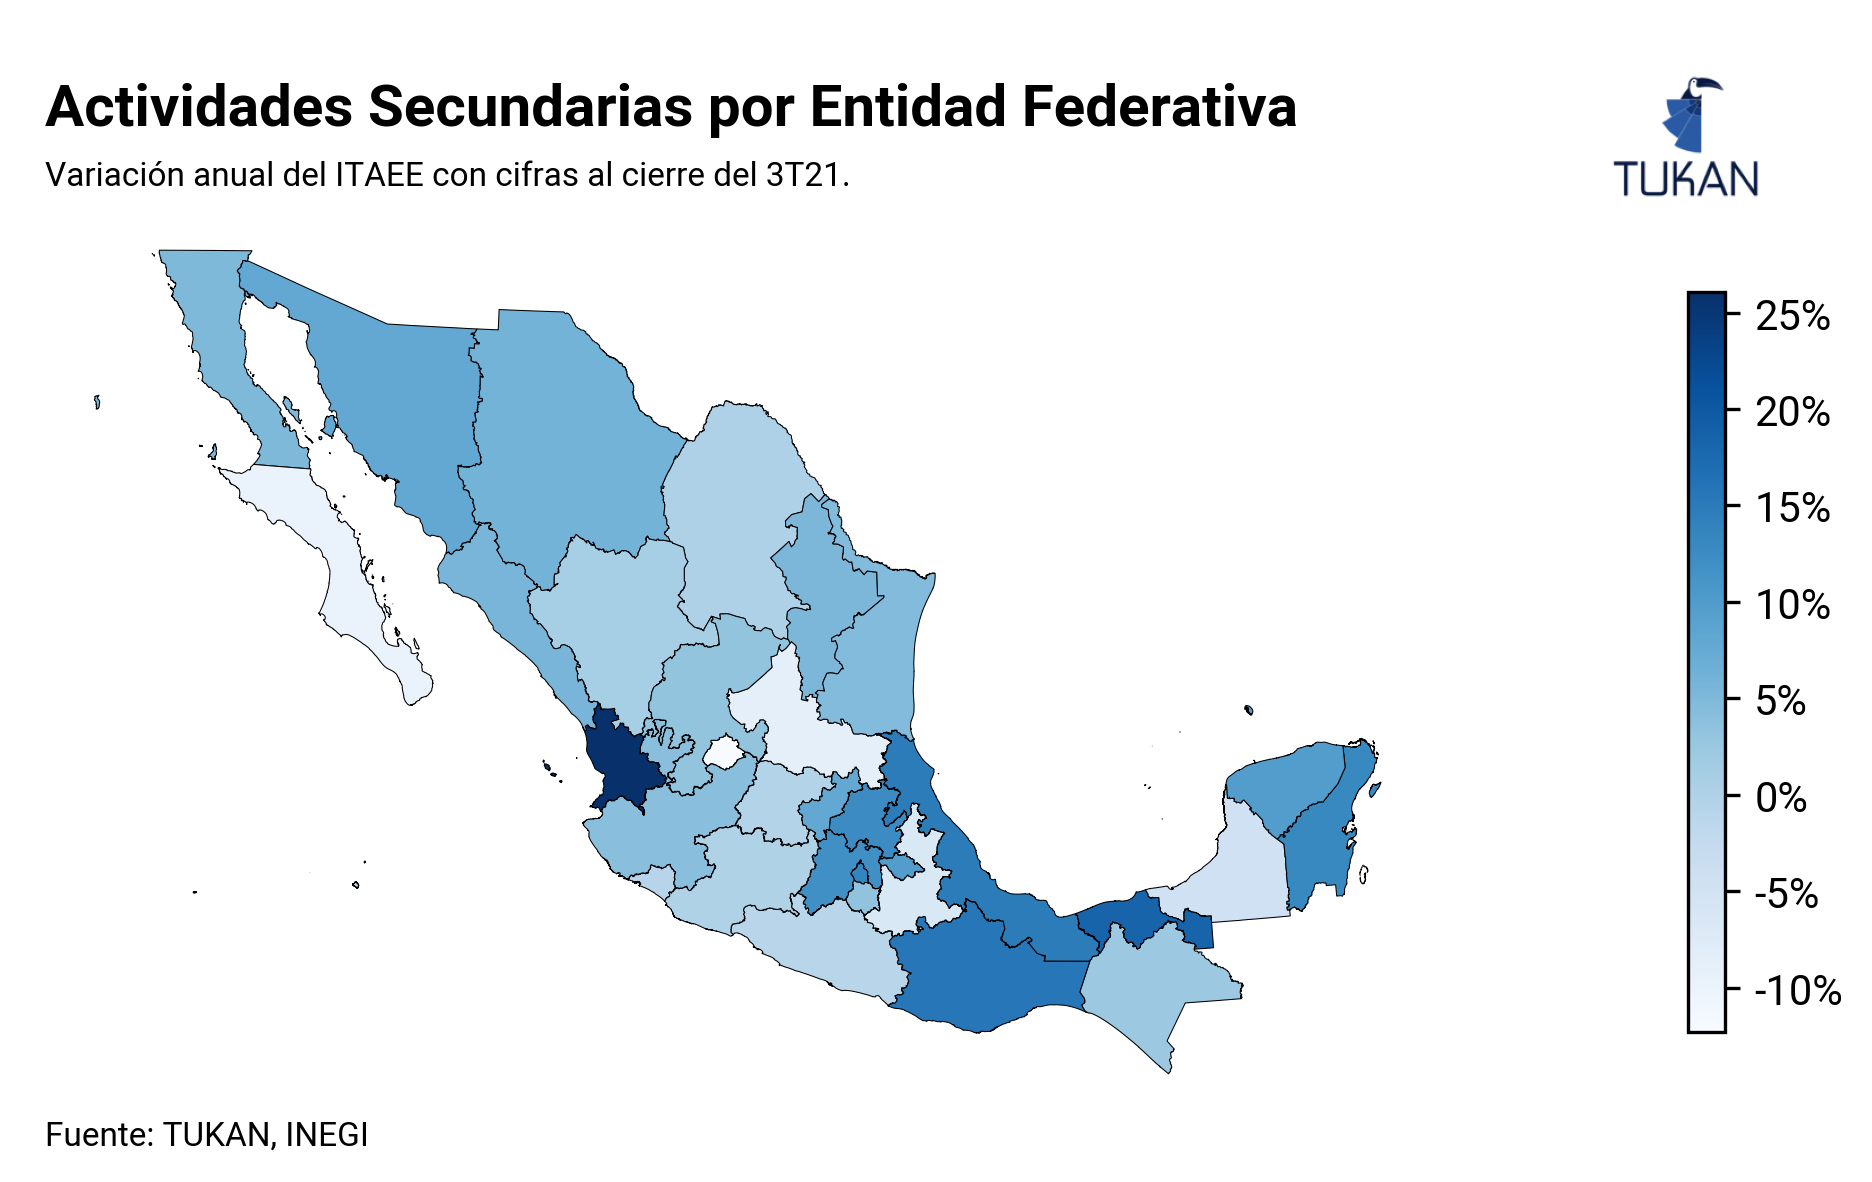

In [427]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("92748be9624675d", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['92748be9624675d'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividades Secundarias por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación anual del ITAEE con cifras al cierre del 3T21.", #change dates
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/yearly_growth_secondary_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  5 . Terciary activities

#### Payload

In [428]:
payload = {
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "8fd5b02b9f891fb"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ]
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [429]:
# data is ready to go
data['date'].unique()

array(['2021-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Merging data and polygons

In [430]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="92748be9624675d", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d
17,18,18,Nayarit,"MULTIPOLYGON (((2161261.691 1008297.886, 21612...",d3d2e9958774cf3,2021-07-01,8fd5b02b9f891fb,Actividades terciarias,a7e5d5a7d084363,Original,Nayarit,0.090445
2,03,03,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",360a302c378e710,2021-07-01,8fd5b02b9f891fb,Actividades terciarias,a7e5d5a7d084363,Original,Baja California Sur,0.243318
22,23,23,Quintana Roo,"MULTIPOLYGON (((4039086.131 787620.709, 403895...",ff9e50f58bb1ce3,2021-07-01,8fd5b02b9f891fb,Actividades terciarias,a7e5d5a7d084363,Original,Quintana Roo,0.271663


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


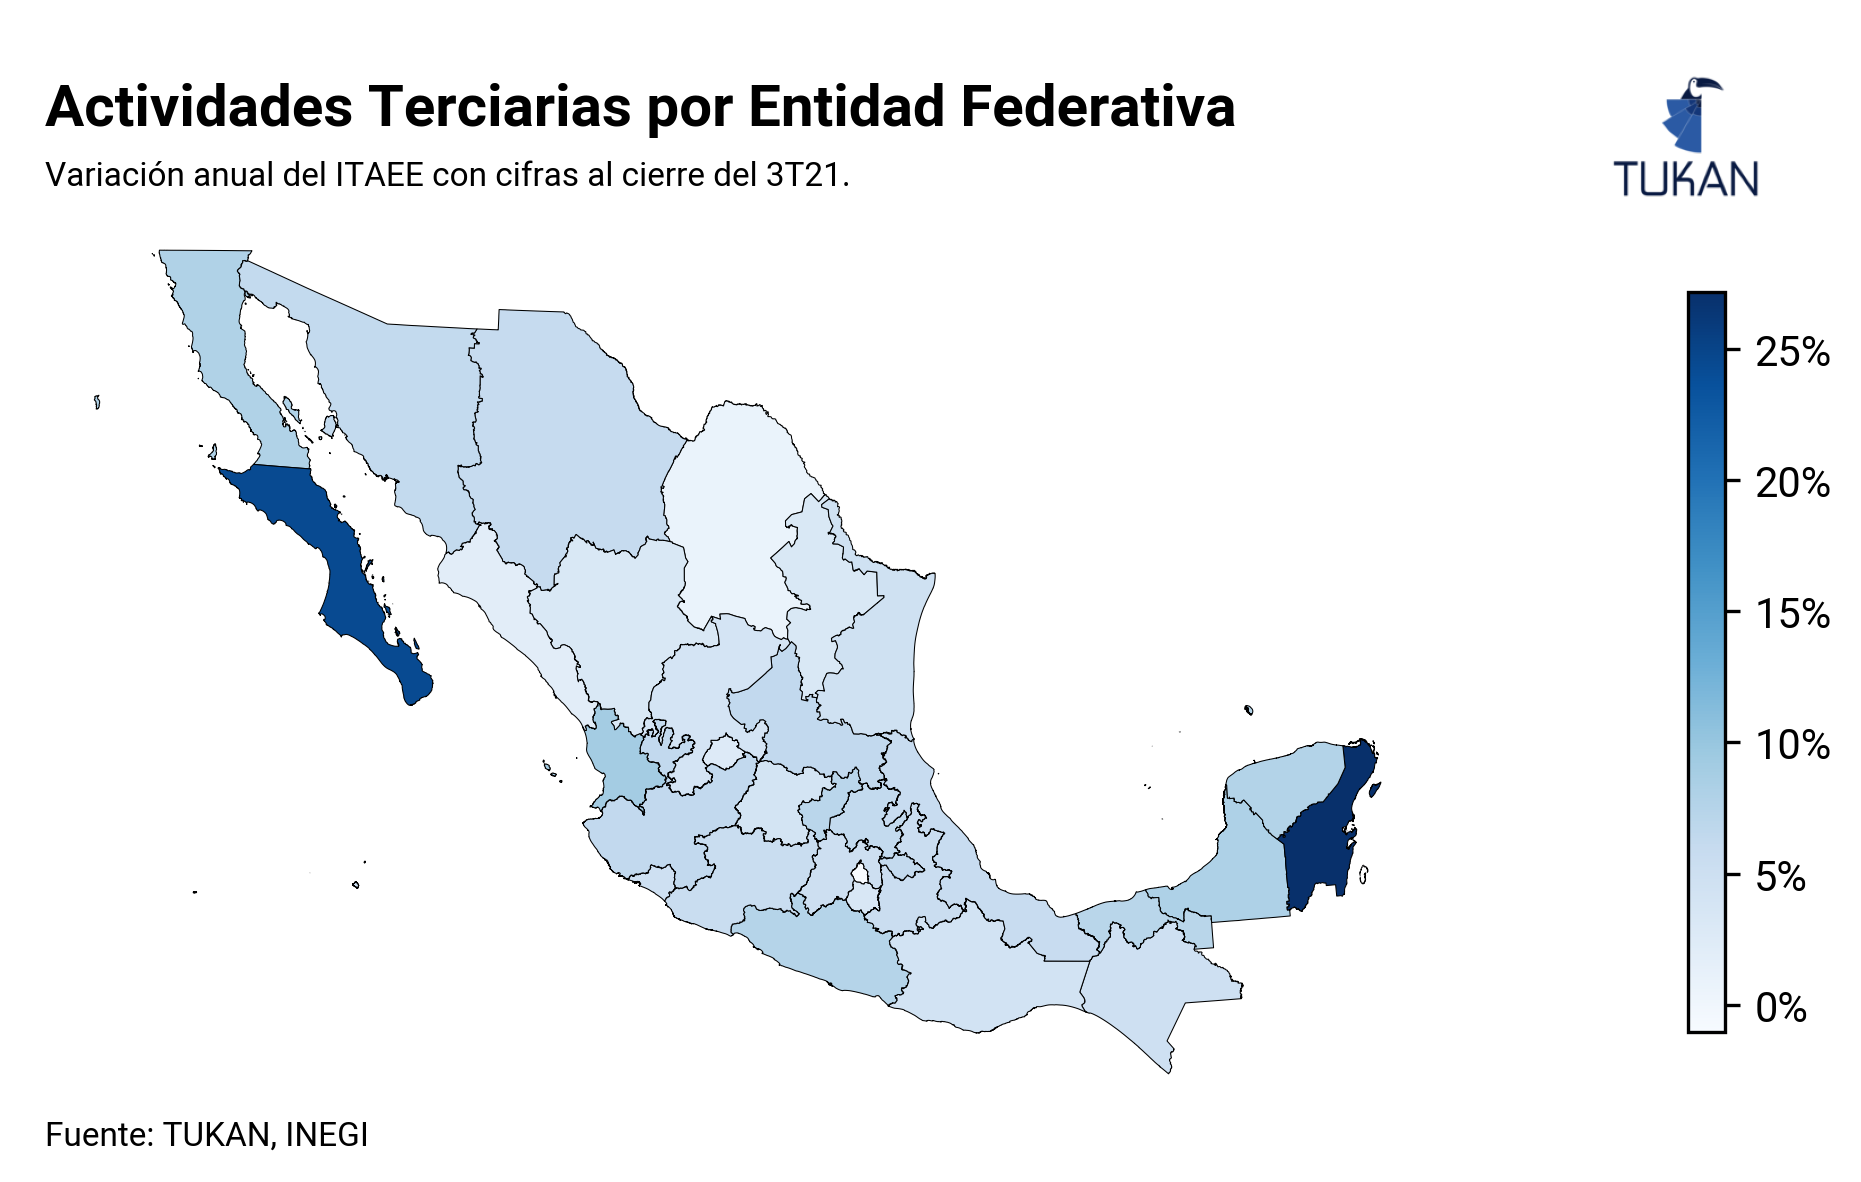

In [431]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("92748be9624675d", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['92748be9624675d'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividades Terciarias por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación anual del ITAEE con cifras al cierre del 3T21.", #change dates
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/yearly_growth_terciary_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)